# Violent Crime Arrests for US States

“This data set contains statistics, in arrests per 100,000 residents,
for assault, murder, and rape in each of the 50 US states in 1973. Also given is the
percent of the population living in urban areas.”

## Introduction

In [1]:
 # Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA #run again if it does not converge the first time
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt
%matplotlib inline

 # load data into a dataframe
arrests_df = pd.read_csv("UsArrests.csv",index_col=0)
arrests_df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


## Data Cleaning
Before we can analyse our data, we need to determine if there is any missing data as well as what types of variables we are dealing with.

In [2]:
arrests_df.info() # getting column datatypes, names and non null record counts per column

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


The ```arrests_df``` info tells us that there is no missing data and we are working with continuous variables

In [3]:
arrests_df.describe() # getting descriptive statisics for all columns

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


#### So far we can confirm the following the following:
- None of the columns contail nulls : Meaning there is no missing data to handle
- All columns are numerical and therefore continuous
- We have 50 entries of city arrests to work with
- Arrests for assult are far more common than any other reason for arrest

## Data Stories & Visualisations

Lets take a look at the distribution of entries for our features by using a pairplot, before we conduct our PCA.

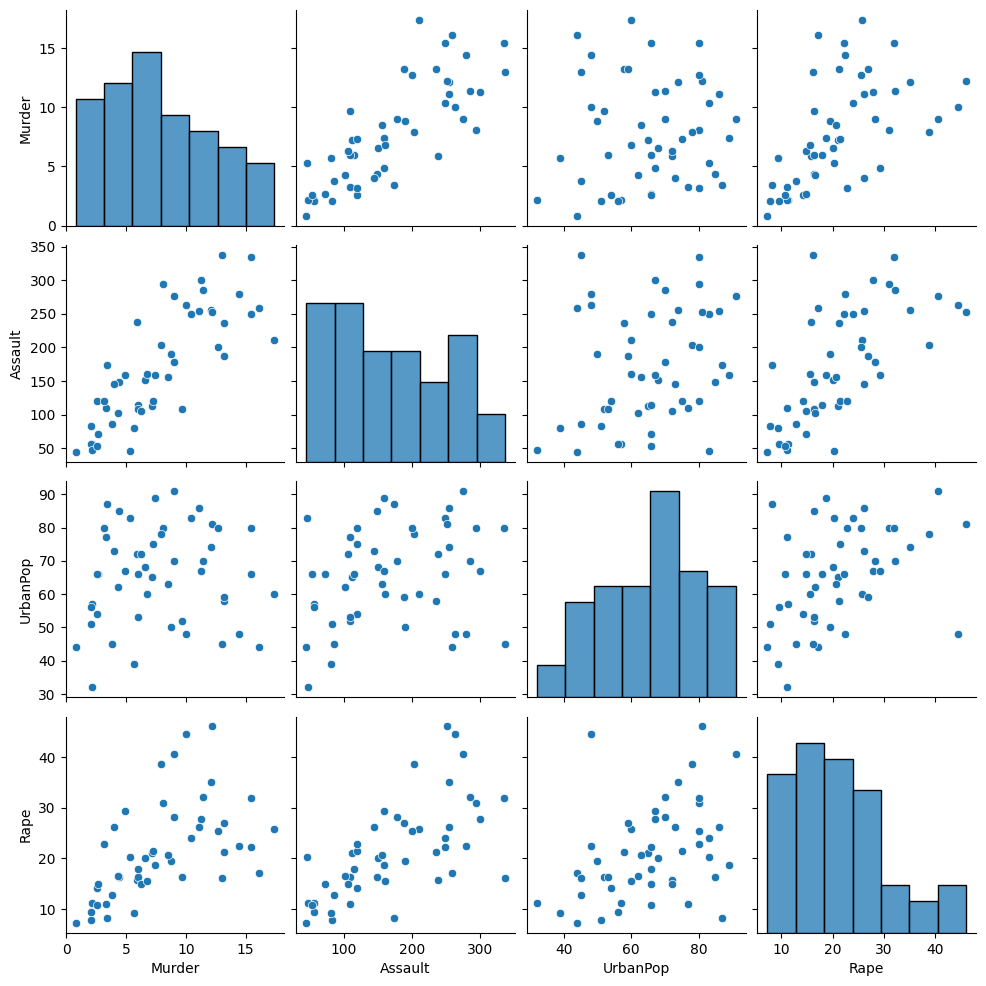

In [4]:
sns.pairplot(arrests_df)

Lets have a look at the distribution of arrests for each city per feature

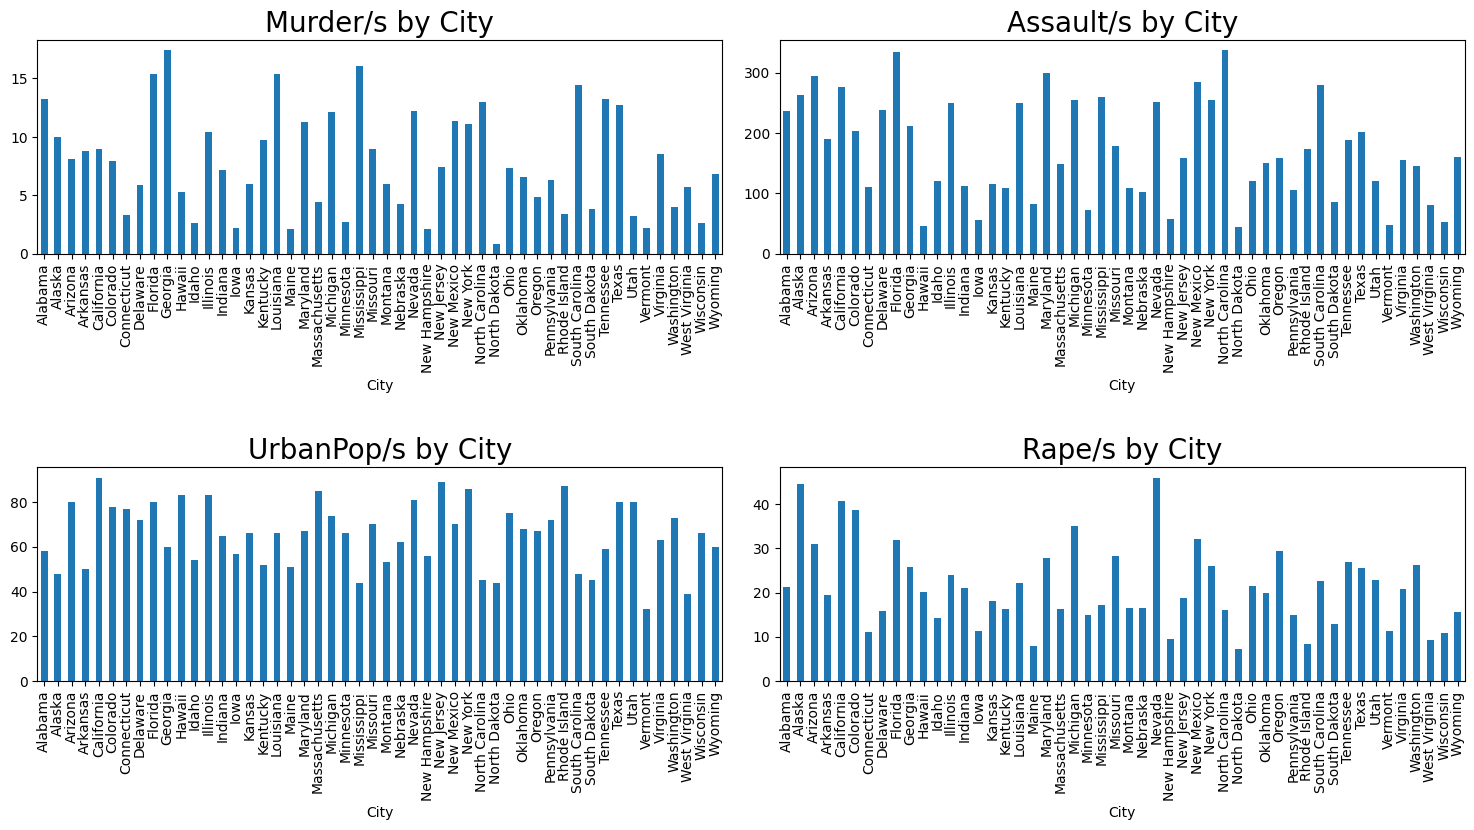

In [5]:
i = 0
fig, axes = plt.subplots(2,2, figsize=(15,7))
fig.tight_layout()
plt.subplots_adjust(hspace=1)
for col in arrests_df.columns:
    i = i + 1
    plt.subplot(2,2,i)
    arrests_df.groupby('City')[col].max().plot(kind='bar')
    plt.title(f'{col}/s by City', fontsize = 20)

#### Observations:
- Georgia has the highest murder rate
- North Dakota has the lowest murder rate
<br>

- Florida and North Carolina have the highest assault rates
- Hawaii, North Dakota and Vermont have the lowest assault rates
<br>

- Califronia and New Jersey have the highest urban population
- Vermont has the lowest urban population
<br>

- Alaska and Nevada have the highest rape rates
- Maine, North Dakota and Rhode Island have the lowest rape rates 

### PCA: Unstandardised Data

In [6]:
# np.set_printoptions(precision=2)

 # get features
x = arrests_df.values.squeeze()

 # create PCA mode fit x
pca = PCA()
pcaX = pca.fit_transform(x) 

 # apply pca to new dataframe
arrests_pca = pd.DataFrame(pcaX)
arrests_pca.head()

,0,1,2,3
0,64.802164,11.448007,-2.494933,2.407901
1,92.827450,17.982943,20.126575,-4.094047
2,124.068216,-8.830403,-1.687448,-4.353685
3,18.340035,16.703911,0.210189,-0.520994
4,107.422953,-22.520070,6.745873,-2.811826


In [7]:
std = arrests_df.describe().transpose()["std"]
varience = pca.explained_variance_ratio_
cumulativeProp = np.cumsum(pca.explained_variance_)

print(f"Standard deviation: {std.values}")
print(f"Variance: {std.values}")
print(f"Cumulative Proportion: {cumulativeProp}")

Standard deviation: [ 4.35550976 83.33766084 14.4747634   9.36638453]
Variance: [ 4.35550976 83.33766084 14.4747634   9.36638453]
Cumulative Proportion: [7011.11485102 7213.10721735 7255.2198681  7261.38411429]


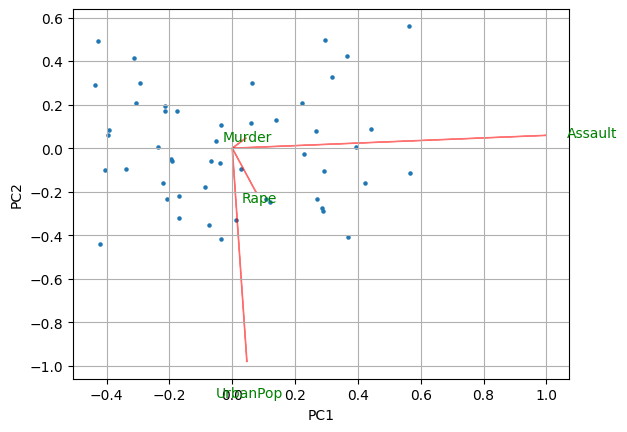

In [8]:
columns = arrests_df.columns

 # create biplot method
def biplot(score,coeff,labels=None,points=None):
    x_std = score[:,0]
    y_std = score[:,1]
    n = coeff.shape[0]
    
    scalex = 1.0/(x_std.max() - x_std.min())
    scaley = 1.0/(y_std.max() - y_std.min())

    fig, ax = plt.subplots()    

    ax.scatter(x_std * scalex,y_std * scaley,s=5)

    for i in range(0,len(x_std)):
        txt = arrests_df.iloc[i]
#         ax.annotate(txt, (x_std[i]* scalex, y_std[i]* scaley)) 

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, columns[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

 # plot biplot
biplot(pcaX[:,0:2],np.transpose(pca.components_[0:2, :]),list(columns),list(arrests_df))
plt.show()

In [9]:
 # Feature importance
 # components x features - access at index 0 to get the first component
pc1 = abs( pca.components_[0] )
pc2 = abs( pca.components_[1] )

features = pd.DataFrame()
features["Features"] = list(columns)
features["PC1 Importance"] = pc1
features["PC2 Importance"] = pc2
features

,Features,PC1 Importance,PC2 Importance
0,Murder,0.041704,0.044822
1,Assault,0.995221,0.058760
2,UrbanPop,0.046336,0.976857
3,Rape,0.075156,0.200718


In [10]:
 # get features
Xstd = StandardScaler().fit_transform(x)

 # create PCA mode fit x
stdPca = PCA()
pcaXstd = stdPca.fit_transform(Xstd) 

 # apply pca to new dataframe
arrests_pca = pd.DataFrame(pcaXstd)
arrests_pca.head()

,0,1,2,3
0,0.985566,1.133392,-0.444269,0.156267
1,1.950138,1.073213,2.040003,-0.438583
2,1.763164,-0.745957,0.054781,-0.834653
3,-0.141420,1.119797,0.114574,-0.182811
4,2.523980,-1.542934,0.598557,-0.341996


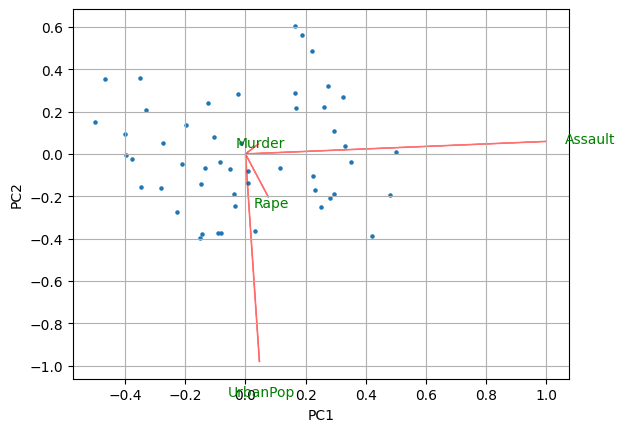

In [11]:
 # plot biplot
biplot(pcaXstd[:,0:2],np.transpose(pca.components_[0:2, :]),list(columns),list(arrests_df))
plt.show()

In [12]:
 # Feature importance
 # components x features - access at index 0 to get the first component
pc1 = abs( stdPca.components_[0] )
pc2 = abs( stdPca.components_[1] )

features = pd.DataFrame()
features["Features"] = list(columns)
features["PC1 Importance"] = pc1
features["PC2 Importance"] = pc2
features

,Features,PC1 Importance,PC2 Importance
0,Murder,0.535899,0.418181
1,Assault,0.583184,0.187986
2,UrbanPop,0.278191,0.872806
3,Rape,0.543432,0.167319


### Observations:
- All features except for 'UrbanPop' contribute pretty evenly to PC1, where 'UrbanPop' contributes significantly lower.
- 'UrbanPop' has the highest contribution to PC2

These observations apply to both the unstandardised PCA and the standardised PCA

C:\Users\elain\AppData\Local\Temp\ipykernel_32576\1754536806.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)
C:\Users\elain\AppData\Local\Temp\ipykernel_32576\1754536806.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,2)


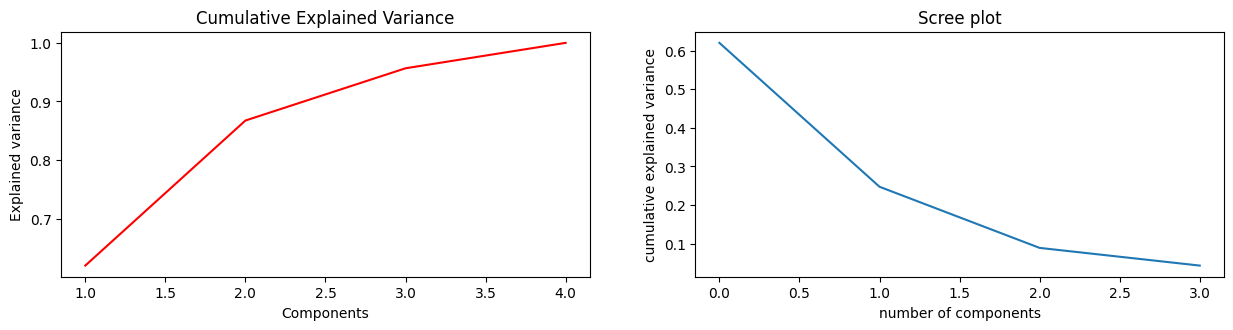

In [13]:
fig, axes = plt.subplots(1,2, figsize=(15,7))

 # Cumulative variance plot
plt.subplot(2,2,1)

plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(stdPca.explained_variance_ratio_ )+1),
         np.cumsum(stdPca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

# Scree plot
plt.subplot(2,2,2)

plt.plot(stdPca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

### Observations: 
- The first 2 components explain just under 90% of the variance. 

We will use these compnents in our cluster analysis

In [14]:
mpca_df = pd.DataFrame(pcaXstd[:,0:2], index = arrests_df.index)
mpca_df.head()

,0,1
City,,
Alabama,0.985566,1.133392
Alaska,1.950138,1.073213
Arizona,1.763164,-0.745957
Arkansas,-0.141420,1.119797
California,2.523980,-1.542934


## K-means Clustering
We can assume from the standardised pca biplot earlier that 2 natural clusters can be formed, therefore we set k-2

C:\Users\elain\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


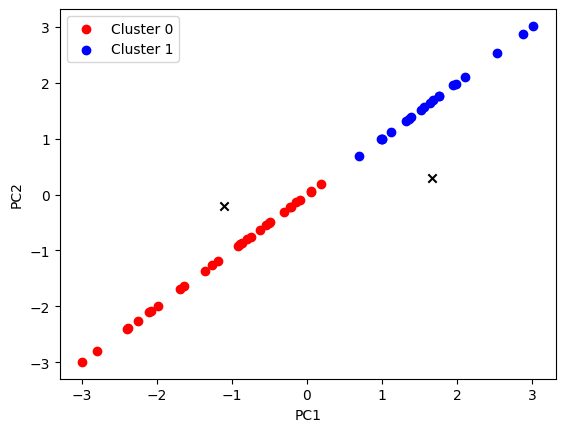

In [15]:
k = 2

# getting two components
x = pcaXstd[:,0]
y = pcaXstd[:,1]

kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
y_pred = kmeans.fit_predict(mpca_df)
colours = 'rbgcmy'
for c in range(k):
  plt.scatter(x[y_pred == c], x[y_pred == c], c = colours[c], label = 'Cluster {}'.format(c))
  plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c = 'black')

# score = round(silhouette_score(X, kmeans.labels_, metric='euclidean'),2)
# plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

### Hierarchial Clustering

C:\Users\elain\AppData\Local\Temp\ipykernel_32576\747998152.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)
C:\Users\elain\AppData\Local\Temp\ipykernel_32576\747998152.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,2)


Text(0.5, 1.0, 'Dendrogram 1: complete linkage')

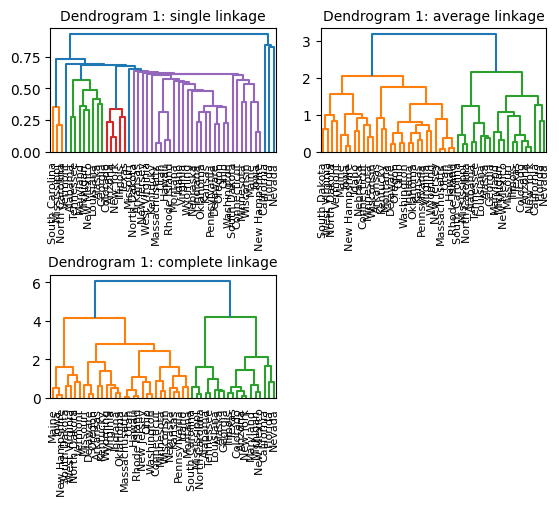

In [16]:
aggC = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
aggC = aggC.fit(mpca_df)

linkageTypes = ['single', 'average', 'complete']

fig, ax = plt.subplots(1, 3)
plt.subplots_adjust(hspace=1)

plt.subplot(2,2,1)
den1 = dendrogram(linkage(mpca_df, method=linkageTypes[0]), labels=mpca_df.index)
plt.title(f'Dendrogram 1: {linkageTypes[0]} linkage', fontsize = 10) 

plt.subplot(2,2,2)
den1 = dendrogram(linkage(mpca_df, method=linkageTypes[1]), labels=mpca_df.index)
plt.title(f'Dendrogram 1: {linkageTypes[1]} linkage', fontsize = 10) 

plt.subplot(2,2,3)
den1 = dendrogram(linkage(mpca_df, method=linkageTypes[2]), labels=mpca_df.index)
plt.title(f'Dendrogram 1: {linkageTypes[2]} linkage', fontsize = 10) 

Text(0.5, 1.0, 'Dendrogram 1: average linkage')

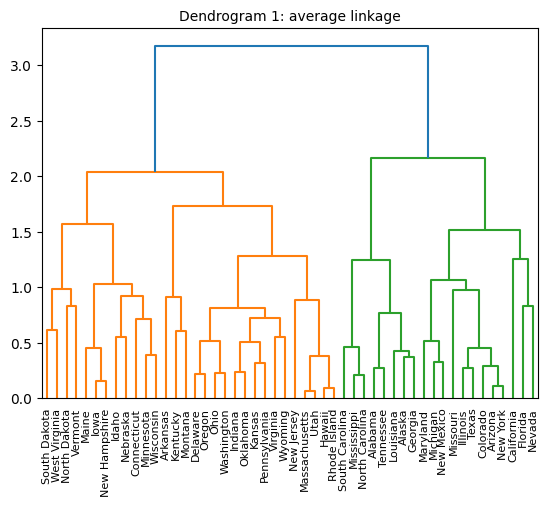

In [17]:
den1 = dendrogram(linkage(mpca_df, method=linkageTypes[1]), labels=mpca_df.index)
plt.title(f'Dendrogram 1: {linkageTypes[1]} linkage', fontsize = 10) 

### Observations:
- We can see that the clusters are similarily distributed over both clustering types in shape